### This notebook is the original version, where we used it to test on public dset

I keep it as its own file, so there is a reference preserved


## 0. Setup

In [17]:
# Enable autoreload so edits to modules are picked up without restarting the kernel
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
## Utils to read data

from enum import Enum
from pathlib import Path
import sys



DATA_PATH_PREFIX = Path.cwd() / "data/SAMD21_Fan_Demo-"

# go to project root
root = str(Path.cwd().parent)
sys.path.append(root)
print("Root: ", root)

class DataType(Enum):
    Normal = 1
    Blocked = 2
    Interference = 3
    OFF = 4


def get_data_path(datatype: DataType, index: int):

    if datatype == DataType.Interference:
        strcode = "Blade Interference"
    
    elif datatype == DataType.Normal:
        strcode = "Fan ON"
    
    elif datatype == DataType.Blocked:
        strcode = "Blocked Flow"
    
    elif datatype == DataType.OFF:
        strcode = "Fan OFF"
    
    postfix = strcode + f"_{index:03d}" + ".csv"
    return str(DATA_PATH_PREFIX) + postfix



Root:  /home/btanady/fourth_year/cpen491


## 1. Prepare training data

In [19]:
from fdd_system.ML.common.config.operating_types import OperatingCondition
from experiment.utils import prepare_training_data

# prepare_training_data expects Mapping[int, list[str]], so convert Path objects to str
NORMAL_FILES = [str(get_data_path(DataType.Normal, i)) for i in range(1, 5)]
FAULTY_FILES = [str(get_data_path(DataType.Blocked, i)) for i in range(1, 4)]


training_data = {
    OperatingCondition.NORMAL.value: NORMAL_FILES,
    OperatingCondition.BLOCKED_AIRFLOW.value: FAULTY_FILES
}

data = prepare_training_data(training_data, True, col_names=["AccelerometerX", "AccelerometerY", "AccelerometerZ"])

## 2. Preprocessing (TODO)

In [20]:
from fdd_system.ML.common.classification.preprocessor import BasicPreprocessor, DummyPreprocessor

preprocessor = DummyPreprocessor()
preprocessed = preprocessor.preprocess(data)

## 3. Embedding

In [21]:
from fdd_system.ML.common.classification.embedder import MLEmbedder1

embedder = MLEmbedder1()
embeddings = embedder.embed(data)
embeddings[0]



array([ 2.16054300e+03,  6.23703972e+01,  2.16144307e+03,  2.40344509e+02,
        1.04963276e+00, -1.75293529e-01, -1.04108844e+00,  4.07731862e+02,
        4.80705504e+02,  2.54304043e+04,  1.17897459e+00,  6.40625000e+01,
        3.50362576e-01,  3.35692103e+03,  8.78582132e-01,  3.49187785e+01,
        9.13903382e-03,  1.11386205e+02,  2.91522882e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  6.86014704e+03,  4.35830876e-02,  4.48437500e+02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.85255280e-02,  9.68446864e-01,  1.30276081e-02,
        2.43902439e-02,  6.40625000e+01,  2.05000000e+01])

## 3.1 Optional PCA - observe how good are the embeddings

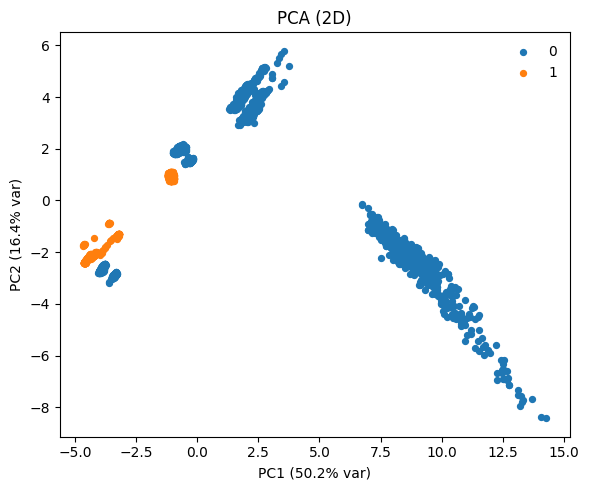

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

def plot_pca_2d(embeddings, labels):
    emb_df = pd.DataFrame(embeddings)
    X = StandardScaler().fit_transform(emb_df)
    y = labels


    pca = PCA(n_components=2)
    Z = pca.fit_transform(X)

    plt.figure(figsize=(6,5))
    if y is None:
        plt.scatter(Z[:,0], Z[:,1], s=18)
    else:
        for cls in np.unique(y):
            m = (y == cls)
            plt.scatter(Z[m,0], Z[m,1], s=18, label=str(cls))
        plt.legend(frameon=False)

    evr = pca.explained_variance_ratio_
    plt.xlabel(f"PC1 ({evr[0]*100:.1f}% var)")
    plt.ylabel(f"PC2 ({evr[1]*100:.1f}% var)")
    plt.title("PCA (2D)")
    plt.tight_layout()
    plt.show()


labels = [d.label for d in data]

plot_pca_2d(embeddings, labels)


## 4. Training

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from joblib import dump, load
import os
from pathlib import Path

# Convert list of dicts to DataFrame
X = embeddings
y = [d.label for d in data]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)


# Train classifier
clf = RandomForestClassifier(n_estimators=10, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Number of test packets: ", len(y_test))
print("Accuracy: ", sum(y_test == y_pred) / len(y_test))

os.makedirs("weights", exist_ok=True)
dump(clf, "weights/rf_model.joblib")


[[929   0]
 [  0 715]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       929
           1       1.00      1.00      1.00       715

    accuracy                           1.00      1644
   macro avg       1.00      1.00      1.00      1644
weighted avg       1.00      1.00      1.00      1644

Number of test packets:  1644
Accuracy:  1.0


['weights/rf_model.joblib']

## 5. Extra test
Seems odd that the accuracy is too good, let me try on dataset that was never fed to the model

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       587
           1       1.00      1.00      1.00       591

    accuracy                           1.00      1178
   macro avg       1.00      1.00      1.00      1178
weighted avg       1.00      1.00      1.00      1178

Number of test packets:  1178
Accuracy:  1.0


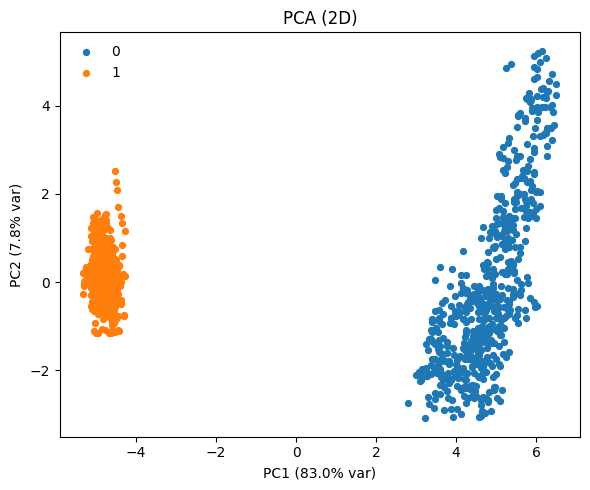

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from joblib import dump, load
import os
from pathlib import Path

NORMAL_FILES_2 = [str(get_data_path(DataType.Normal, i)) for i in range(5, 6)]
FAULTY_FILES_2 = [str(get_data_path(DataType.Blocked, i)) for i in range(4, 5)]
raw_data = {
    OperatingCondition.NORMAL.value: NORMAL_FILES_2,
    OperatingCondition.BLOCKED_AIRFLOW.value: FAULTY_FILES_2
}

data = prepare_training_data(raw_data, True, col_names=["AccelerometerX", "AccelerometerY", "AccelerometerZ"])
X = embedder.embed(data)
y_true = np.array([d.label for d in data])

clf_loaded: RandomForestClassifier = load("weights/rf_model.joblib")
y_pred = clf_loaded.predict(X)

print(classification_report(y_true, y_pred))
print("Number of test packets: ", len(y_true))
print("Accuracy: ", sum(y_true == y_pred) / len(y_true))

plot_pca_2d(X, y_true)


## 6. Exmple of using ClassificationPipeline for inference

Q: Why do we need such Wrapper?  
Ans: It might seem "stupid" for some, but treat it as an investment. Such structuring reduces later cost of development.  
Imagine when we want to integrate with the hardware for demo, it's easier to not think much and just assemble the pipeline  
and then call pipeline.infer() to predict if a particular input is "normal" or "blocked_airflow"



In [25]:
from fdd_system.ML.inference.classification_pipeline import ClassificationPipeline
from fdd_system.ML.common.classification.embedder import MLEmbedder1
from fdd_system.ML.common.classification.preprocessor import DummyPreprocessor, BasicPreprocessor
from fdd_system.ML.common.classification.inferrer import SklearnMLInferrer


# 1. load model
model: RandomForestClassifier = load("weights/rf_model.joblib")

# 2. load pipeline
pipeline = ClassificationPipeline(
    preprocessor=BasicPreprocessor(),
    embedder=MLEmbedder1(),
    inferrer=SklearnMLInferrer(model=model)
)

# 3. get data ready
NORMAL_FILES_2 = [str(get_data_path(DataType.Normal, i)) for i in range(5, 6)]
FAULTY_FILES_2 = [str(get_data_path(DataType.Blocked, i)) for i in range(4, 5)]
raw_data = {
    OperatingCondition.NORMAL.value: NORMAL_FILES_2,
    OperatingCondition.BLOCKED_AIRFLOW.value: FAULTY_FILES_2
}
data = prepare_training_data(raw_data, True, col_names=["AccelerometerX", "AccelerometerY", "AccelerometerZ"])
y_true = np.array([d.label for d in data])



Note that on deployment, it is highly likely we only declare pipeline once, and reuse it over and over again  
this reduces the cost. That's why I split the code here (to measure performance more reliably)

NB: My laptop takes about 3 ms to infer a packet with WINDOW_LENGTH = 100, Sampling_rate = 400 Hz  
So it takes 3ms to process 0.25 s of data for now

In [26]:
import time

start = time.perf_counter()
# 4. run inference
y_pred = pipeline.predict(data)

# 5. Get accuracy
print(classification_report(y_true, y_pred))
print("Number of test packets: ", len(data))
print("Accuracy: ", sum(y_true == y_pred) / len(y_true))

end = time.perf_counter()

interval = end - start 
time_per_packet = (interval * 1000) / len(data)
print(f"Pipeline inference time: {time_per_packet:.2f} ms per packet")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       587
           1       1.00      0.98      0.99       591

    accuracy                           0.99      1178
   macro avg       0.99      0.99      0.99      1178
weighted avg       0.99      0.99      0.99      1178

Number of test packets:  1178
Accuracy:  0.9881154499151104
Pipeline inference time: 1.37 ms per packet


## 7. CNN ##

**Embedding** 

we will first use STFT to transform the original data into a 2D image

TODO: nperseg, noverlap, and nfft should be automatically adjusted

ex:
nperseg, noverlap, nfft = `auto_stft_params(SensorConfig)`


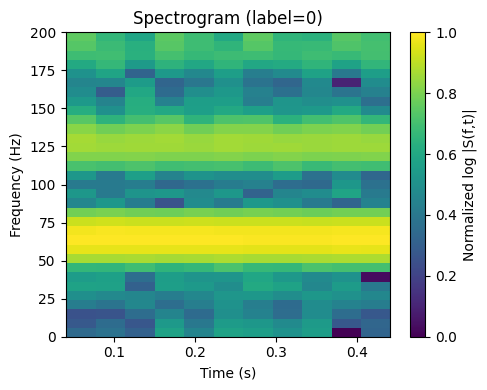

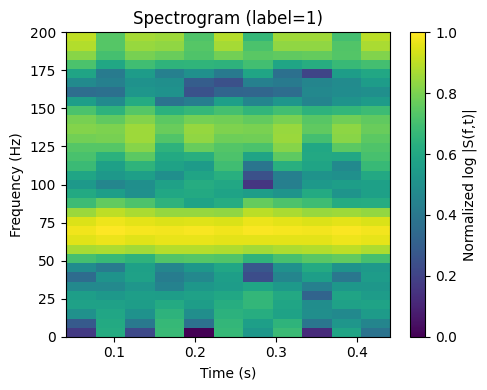

In [27]:
from fdd_system.ML.common.classification.embedder import Spectrogram2DEmbedder

embedder2d = Spectrogram2DEmbedder(
    nperseg=32, # window length (in samples) used for each STFT segment
    noverlap=16, # number of overlapped samples between consecutive segments
    nfft=64, # FFT size
)

windows = prepare_training_data(training_data, shuffle=False, col_names=["AccelerometerX", "AccelerometerY", "AccelerometerZ"])

w0 = next(w for w in windows if w.label == 0)
w1 = next(w for w in windows if w.label == 1)

embedder2d.plot_spectrogram_window(w0)
embedder2d.plot_spectrogram_window(w1)


We can observe significant differences in images with different labels, indicating that this is learnable by CNN

Next, prepare a `Dataset` class for the torch API

In [28]:
import torch
from torch.utils.data import Dataset, DataLoader

class SpectrogramDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


This CNN is reasonably small but expressive. It uses three conv blocks + adaptive pooling

$x \in \mathbb{R}^{1\times F\times T}$, F stands for freq, T stands for time

$z_1 = \gamma_1 \frac{(x * w_1) - \mu_k}{\sqrt{\sigma_1^2 + \epsilon}} + \beta_1 \in \mathbb{R}^{16 \times F\times T}$

$h_1 = Pool_{max} (ReLU(z_1)) \in \mathbb{R}^{16 \times \frac{F}{2}\times \frac{T}{2}}$

$z_2 = \gamma_2 \frac{(h_1 * w_2) - \mu_k}{\sqrt{\sigma_2^2 + \epsilon}} + \beta_2 \in \mathbb{R}^{32 \times \frac{F}{2}\times \frac{T}{2}}$

$h_2 = Pool_{max} (ReLU(z_2)) \in \mathbb{R}^{32 \times \frac{F}{4}\times \frac{T}{4}}$

$z_3 = \gamma_3 \frac{(h_2 * w_3) - \mu_k}{\sqrt{\sigma_3^2 + \epsilon}} + \beta_3 \in \mathbb{R}^{64 \times \frac{F}{4}\times \frac{T}{4}}$

$h_3 = Pool_{max} (ReLU(z_3)) \in \mathbb{R}^{64 \times \frac{F}{8}\times \frac{T}{4}}$ here, our T/4 = 1, so I cannot do futher

$h_4 = 2DAvg(h_3) \in \mathbb{R}^{64 \times 1 \times 1}$

$h_5 = Flatten(h_4) \mathbb{R}^{64}$

$h_6 = ReLU(w_6 h_5 + b_6) \in \mathbb{R}^{128 \times 64}$

$y = w_7 Dropout(h_6) + b_7 \in \mathbb{R}^{n_{class}}$

In [29]:
import torch.nn as nn

class FanSpectrogramCNN(nn.Module):
    def __init__(self, n_classes: int = 2):
        super().__init__()

        self.features = nn.Sequential(
            # (N, 1, F, T) -> (N, 16, F/2, T/2)
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)), # pool both freq & time

            # (N, 16, F/2, T/2) -> (N, 32, F/4, T/4)
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2)),

            # (N, 32, F/4, T/4) -> (N, 64, F/8, T/4)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 1)), # pool freq only, since the time dim may be small
        )

        # Global average pooling: (N, 64, H, W) -> (N, 64, 1, 1)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(), #(N, 64)
            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, n_classes), # I don't use softmax here since CrossEntropyLoss does it internally, and I don't care about probabilities but only the scores
        )

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x


In [ ]:
X = embedder2d.embed(data) # (N, 1, F, T)
y = np.array([d.label for d in data], dtype=np.int64)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.4,
    random_state=42,
    stratify=y, # keeps class balance
)

train_dataset = SpectrogramDataset(X_train, y_train)
test_dataset  = SpectrogramDataset(X_test,  y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, drop_last=False)


NOTE: This training took 2.2s on a RTX 4090 graphics card

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_classes = len(np.unique(y_train))
model = FanSpectrogramCNN(n_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()  # y is 0/1, so this is fine
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)

        _, preds = torch.max(outputs, dim=1) # here is same as argmax/softmax
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

    train_loss = running_loss / running_total
    train_acc = running_correct / running_total

    # Evaluate on test set each epoch
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(
        f"Epoch [{epoch+1:02d}/{num_epochs}] "
        f"Train Loss: {train_loss:.4f}"
    )


Using device: cuda
Epoch [01/30] Train Loss: 0.5193
Epoch [02/30] Train Loss: 0.1785
Epoch [03/30] Train Loss: 0.0461
Epoch [04/30] Train Loss: 0.0325
Epoch [05/30] Train Loss: 0.0234
Epoch [06/30] Train Loss: 0.0268
Epoch [07/30] Train Loss: 0.0123
Epoch [08/30] Train Loss: 0.0130
Epoch [09/30] Train Loss: 0.0106
Epoch [10/30] Train Loss: 0.0082
Epoch [11/30] Train Loss: 0.0081
Epoch [12/30] Train Loss: 0.0127
Epoch [13/30] Train Loss: 0.0053
Epoch [14/30] Train Loss: 0.0057
Epoch [15/30] Train Loss: 0.0109
Epoch [16/30] Train Loss: 0.0111
Epoch [17/30] Train Loss: 0.0061
Epoch [18/30] Train Loss: 0.0033
Epoch [19/30] Train Loss: 0.0025
Epoch [20/30] Train Loss: 0.0021
Epoch [21/30] Train Loss: 0.0032
Epoch [22/30] Train Loss: 0.0017
Epoch [23/30] Train Loss: 0.0013
Epoch [24/30] Train Loss: 0.0015
Epoch [25/30] Train Loss: 0.0011
Epoch [26/30] Train Loss: 0.0011
Epoch [27/30] Train Loss: 0.0022
Epoch [28/30] Train Loss: 0.0095
Epoch [29/30] Train Loss: 0.0084
Epoch [30/30] Train Loss

In [32]:
from sklearn.metrics import accuracy_score

model.eval()
all_preds = []
all_labels = []

val_loss = 0.0
val_correct = 0
val_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)

        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)

print("Test accuracy:", val_correct / val_total)


Test accuracy: 1.0
